# Simulation of BBOB F01

Approach:
- SVM with RBF-Kernel
- 1000 random samples

In [1]:
import sys
import pickle

import numpy as np
from scipy.stats import spearmanr, pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sys.path.append('..')
import model
from utils.utils import create_problem, plot_collage, test_function, calculate_eval_metrics, plot_collage_results
from utils.optimizer import plot_optimization, plot_optimization_paths, perform_optimization
from gt_sampling import get_sample

sys.path.append("../misc")
import bbob_deferential as bobby


## Create Groundtruth

In [2]:
n_dim = 2
samples = 1000
seed = 42

problem_f01 = create_problem(1, n_dim, seed)

## Sample from Groundtruth

In [3]:
sample_f01 = get_sample(problem_f01, n_samples=samples, n_dim=2, seed=42, method='random')

c:\Users\Pascal\OneDrive - bwedu\Python Shit\OptimizationTestfunctionGeneration\main\gt_sampling.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sample = torch.tensor(result[i], dtype=torch.float64).reshape((1, n_dim)).float()


In [4]:
X_input = torch.tensor(sample_f01[0], dtype=torch.float32).clone().detach()
y_input = sample_f01[1].float()  

# input with gradients
X_input_grad1 = torch.tensor(np.concatenate((X_input, sample_f01[2]), axis=1), dtype=torch.float32).clone().detach()

C:\Users\Pascal\AppData\Local\Temp\ipykernel_30804\3495846831.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_input = torch.tensor(sample_f01[0], dtype=torch.float32).clone().detach()


## Models for Simulation

### Classic SVM

In [5]:
svm_p1 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf', C=10, gamma=0.6)),
])

In [6]:
svm_p1.fit(X_input, y_input)

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR(C=10, gamma=0.6))])

Export model:

In [7]:
FOLDER = '../models'
svm1 = pickle.loads(open(f'{FOLDER}/SVM_grad.pkl', 'rb').read())

c:\Users\Pascal\DataScience\Anaconda\envs\MachineLearningProject\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Pascal\DataScience\Anaconda\envs\MachineLearningProject\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVR from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Pascal\DataScience\Anaconda\envs\MachineLearningProject\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1

### SVM with gradients 

In [8]:
svm_grad = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf', C=10, gamma=0.6)),
])

In [9]:
# train model with gradients
svm_grad.fit(X_input_grad1, y_input)

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR(C=10, gamma=0.6))])

In [10]:
pickle.dump(svm_grad, open(f'{FOLDER}/SVM-P01-Grads.pkl', 'wb'))

(estimated by nearest neighbor)

In [11]:
# wrap svm and estimate gradients with nearest neighbor
def svm_grad_1nn(X):
    return test_function(X, X_input, X_input_grad1[:, 2:4], svm_grad, method='nearest_neighbor')

(estimated by GPM)

In [12]:
gradient_estimator = MultiOutputRegressor(GaussianProcessRegressor())
gradient_estimator.fit(X_input, X_input_grad1[:, 2:4])

def svm_grad_gpm(X):
    return test_function(X, X_input, X_input_grad1[:, 2:4], svm_grad, method='estimator', gradient_estimator=gradient_estimator)

## Neural Networks

In [30]:
input_dim = 2
hidden_dim = 16
hidden_layers = 8
output_dim = 1
learning_rate = 0.01
num_epochs = 5000
bs = 256

torch.manual_seed(42)

### Classic Neural Network

In [31]:
# initialize model
nn_classic = model.NN(input_dim, hidden_dim, hidden_layers)
optimizer = torch.optim.SGD(nn_classic.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss() 

In [32]:
Y = problem_f01(X_input)
mean, std = Y.mean(), Y.std()
# training loop
for epoch in range(num_epochs):
    # perm = torch.randperm(samples)
    x = X_input#[perm][:bs]
    y = Y#[perm][:bs]

    optimizer.zero_grad()
    trues = (y - mean)/std
    preds = nn_classic(x)
    
    Carloss = criterion(preds.flatten(), trues.flatten())

    # backward and optimize
    Carloss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {Carloss.item():.4f}')

Epoch [100/5000], Loss: 0.9981
Epoch [200/5000], Loss: 0.9977
Epoch [300/5000], Loss: 0.9973
Epoch [400/5000], Loss: 0.9968
Epoch [500/5000], Loss: 0.9962
Epoch [600/5000], Loss: 0.9954
Epoch [700/5000], Loss: 0.9943
Epoch [800/5000], Loss: 0.9927
Epoch [900/5000], Loss: 0.9902
Epoch [1000/5000], Loss: 0.9860
Epoch [1100/5000], Loss: 0.9783
Epoch [1200/5000], Loss: 0.9604
Epoch [1300/5000], Loss: 0.8977
Epoch [1400/5000], Loss: 0.5389
Epoch [1500/5000], Loss: 0.1540
Epoch [1600/5000], Loss: 0.0685
Epoch [1700/5000], Loss: 0.0291
Epoch [1800/5000], Loss: 0.0142
Epoch [1900/5000], Loss: 0.0085
Epoch [2000/5000], Loss: 0.0059
Epoch [2100/5000], Loss: 0.0046
Epoch [2200/5000], Loss: 0.0039
Epoch [2300/5000], Loss: 0.0034
Epoch [2400/5000], Loss: 0.0031
Epoch [2500/5000], Loss: 0.0029
Epoch [2600/5000], Loss: 0.0028
Epoch [2700/5000], Loss: 0.0026
Epoch [2800/5000], Loss: 0.0025
Epoch [2900/5000], Loss: 0.0025
Epoch [3000/5000], Loss: 0.0024
Epoch [3100/5000], Loss: 0.0023
Epoch [3200/5000]

### Taylor-Zehle-Loss Neural Network

In [16]:
input_dim = 2
hidden_dim = 16
hidden_layers = 4
output_dim = 1
learning_rate = 0.0001
num_epochs = 1000
bs = 256

In [17]:
def higher_order_derivatives(f, wrt, n):
    derivatives = []
    for i in range(f.shape[0]):
        f_ = f.select(0, i)
        wrt_ = wrt.select(0, i)
        print(f_.is_leaf)
        for _ in range(n):
            print(f_)
            print(wrt_)
            grads = torch.autograd.grad(f_, wrt_)
            print(grads)
            derivatives.append(grads)
            f_ = grads
    return torch.stack(derivatives)


class KnollHaZeHei(torch.nn.Module):
    def __init__(self, diff_degree, criterion):
        super().__init__()
        self.diff_degree = diff_degree
        self.criterion = criterion

    def forward(self, pred, true, x):
        true = higher_order_derivatives(true, x, self.diff_degree)
        pred = higher_order_derivatives(pred, x, self.diff_degree)
        loss = self.criterion(pred.flatten(), true.flatten())
        return loss

In [18]:

nn_taylor = model.NN(input_dim, hidden_dim, hidden_layers)
optimizer = torch.optim.SGD(nn_taylor.parameters(), lr=learning_rate)
criterion = KnollHaZeHei(1, torch.nn.MSELoss())

In [19]:
# training loop
for epoch in range(num_epochs):
    x = X_input.clone().detach().requires_grad_(True)
    x = x[torch.randperm(samples)][:bs]

    optimizer.zero_grad()
    trues = bobby.create_f01(2)(x)
    preds = nn_taylor(x)
    
    Karloss = criterion(preds, trues, x)

    # backward and optimize
    Karloss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {Karloss.item():.4f}')


False
tensor(991.7938, grad_fn=<SelectBackward0>)
tensor([4.6930, 0.2310], grad_fn=<SelectBackward0>)


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [ ]:
# nn_classic = model.NN(input_dim, hidden_dim, hidden_layers)
# sd = torch.load("../models/f01_mse_nn_model.pt")
# nn_classic.load_state_dict(sd)

### Multioutput Neural Network

see multioutput_nn_experiment --> no sufficient results

### Neural Network with Gradient (Taylor) Loss

In [ ]:
# nn_taylor = model.NN1(input_dim, 16, 8)
# sd = torch.load("../models/f01_taylor_nn_model02.pt")
# nn_taylor.load_state_dict(sd)

## Evaluation

### Graphical Evaluation

In [33]:
x1 = x2 = np.linspace(-5.0, 5.0, 100)
X1, X2 = np.meshgrid(x1, x2)

mesh_samples = np.c_[X1.ravel(), X2.ravel()]
mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)


In [34]:
mesh_results_svm_p1 = svm_p1.predict(mesh_samples_tensor).reshape(X1.shape)

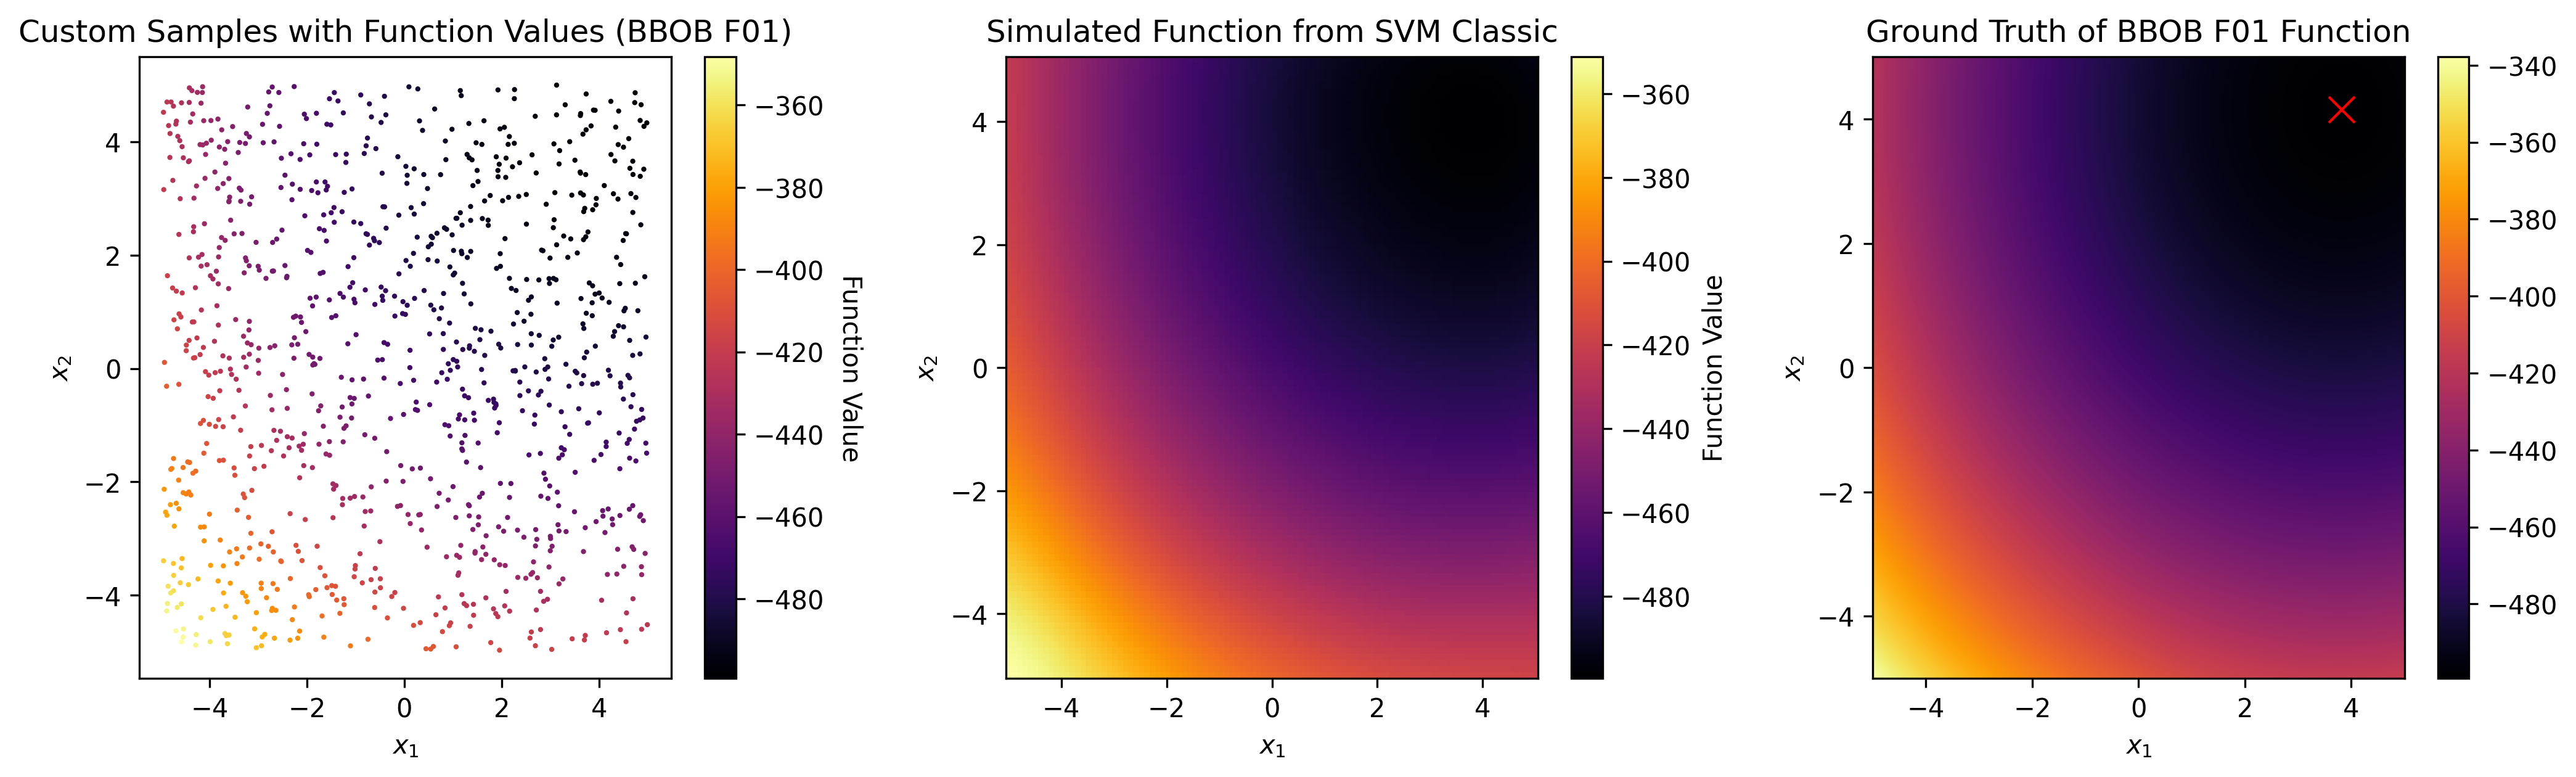

In [35]:
plot_collage(sample_f01[0], sample_f01[1], problem_f01, "BBOB F01", "SVM Classic", X1, X2, mesh_results_svm_p1)
plt.gcf().set_size_inches(14, 4)
plt.gcf().set_dpi(300)
plt.show()

--> on first glance: Classic SVM with RBF-Kernel can simulate the first BBOB function quite well

In [36]:
mesh_results_svm_grad_1nn = svm_grad_1nn(mesh_samples_tensor).reshape(X1.shape)

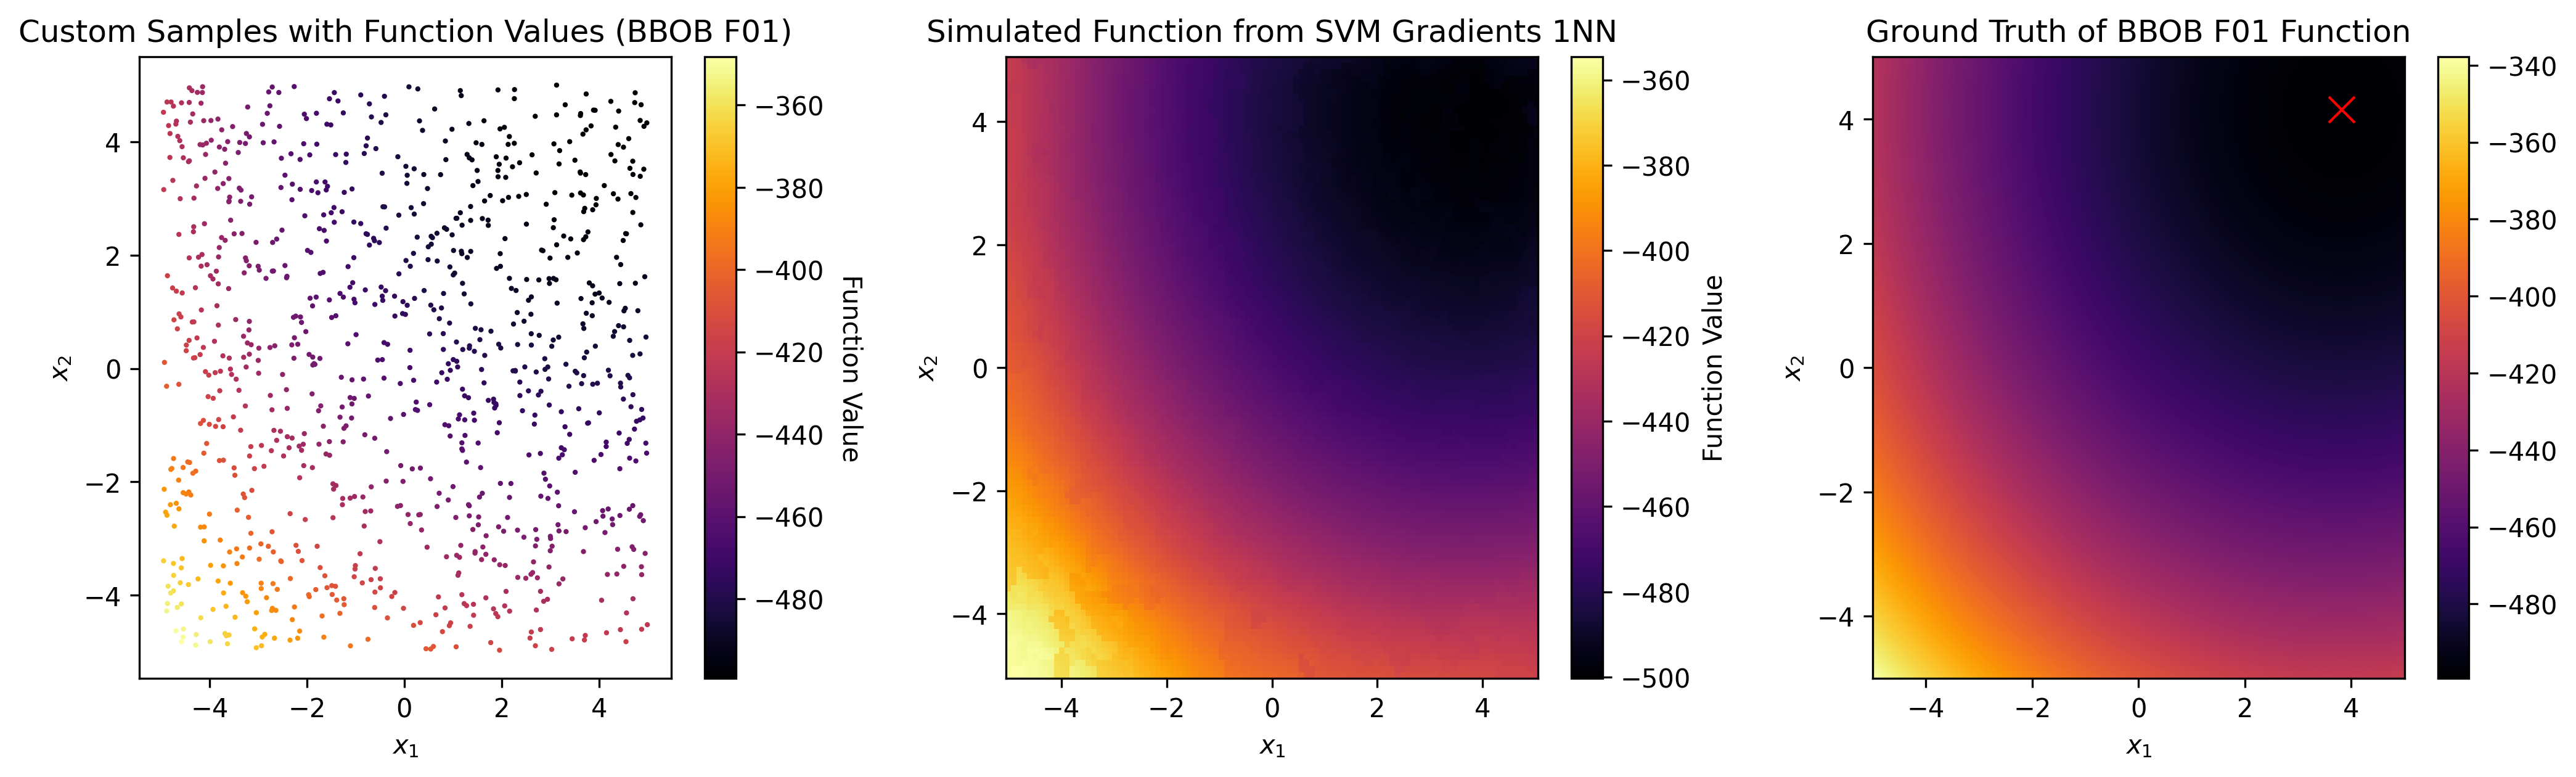

In [37]:
plot_collage(sample_f01[0], sample_f01[1], problem_f01, "BBOB F01", "SVM Gradients 1NN", X1, X2, mesh_results_svm_grad_1nn)
plt.gcf().set_size_inches(14, 4)
plt.gcf().set_dpi(300)
plt.show()

In [38]:
mesh_results_svm_grad_gpm = svm_grad_gpm(mesh_samples_tensor).reshape(X1.shape)

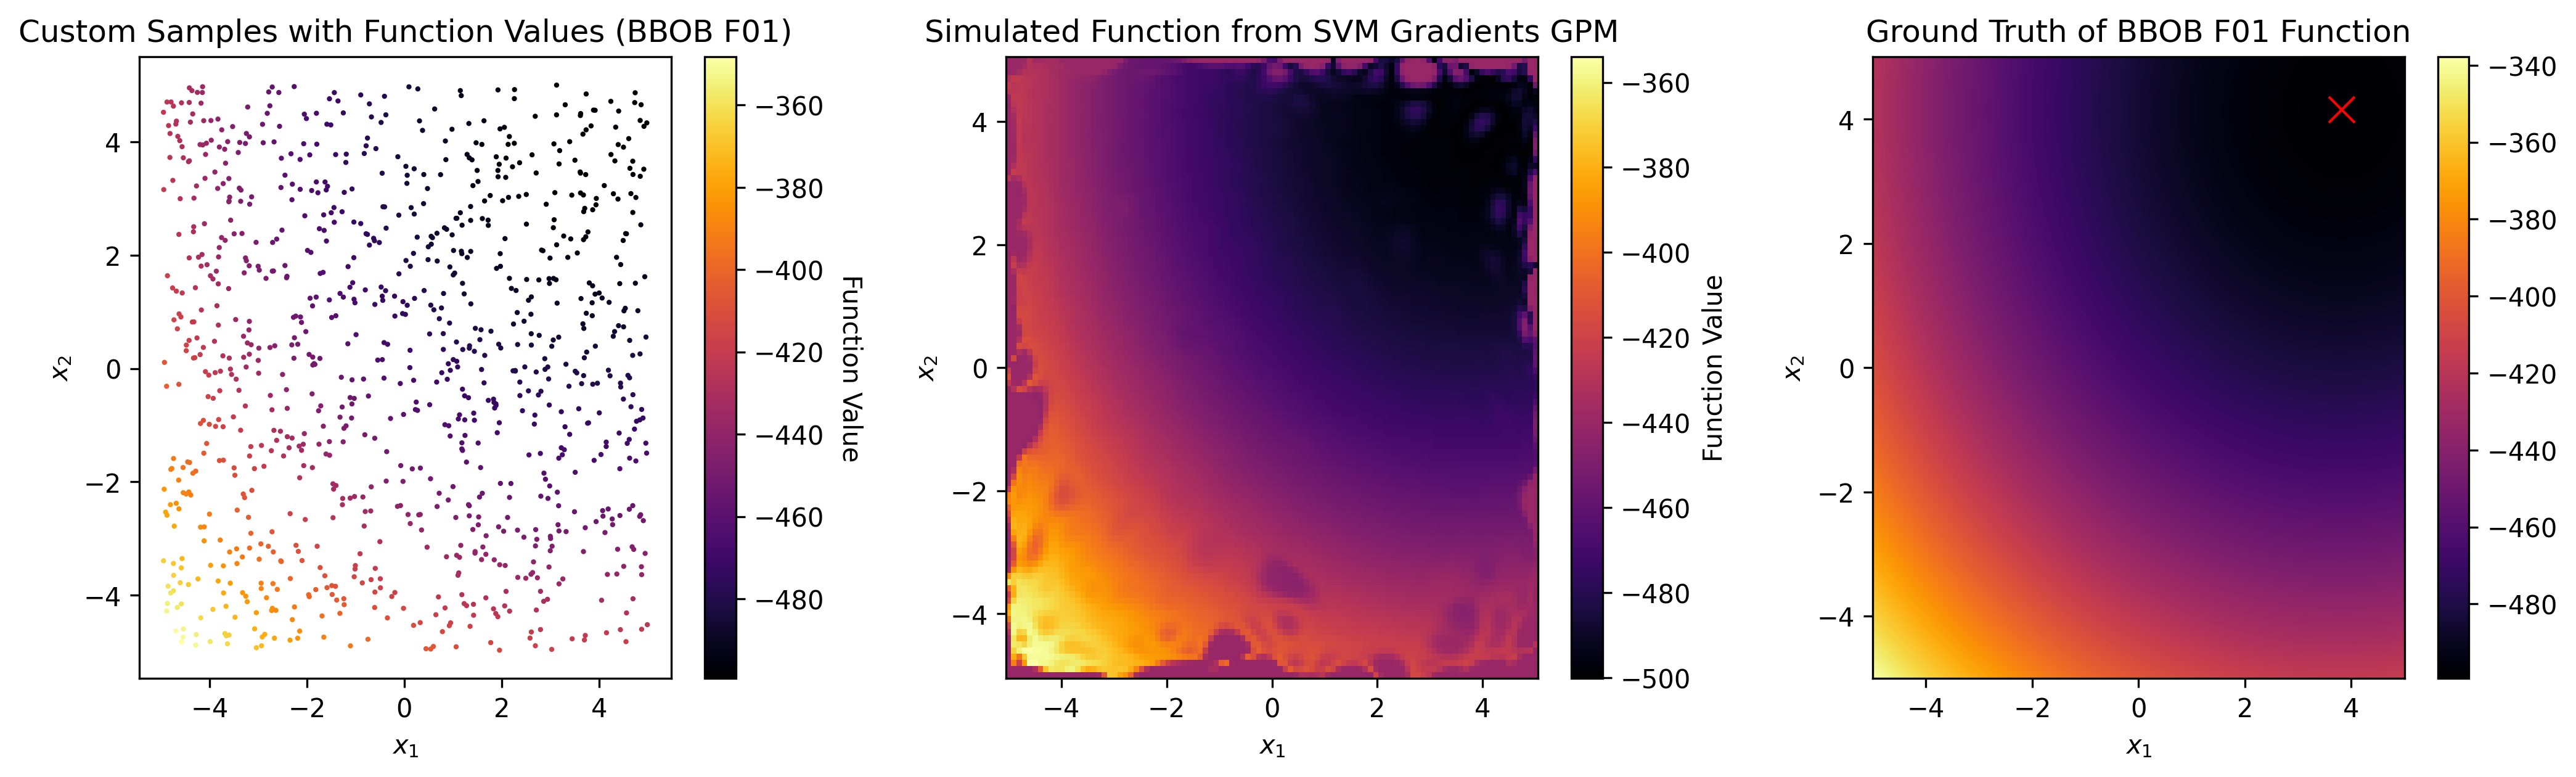

In [39]:
plot_collage(sample_f01[0], sample_f01[1], problem_f01, "BBOB F01", "SVM Gradients GPM", X1, X2, mesh_results_svm_grad_gpm)
plt.gcf().set_size_inches(14, 4)
plt.gcf().set_dpi(300)
plt.show()

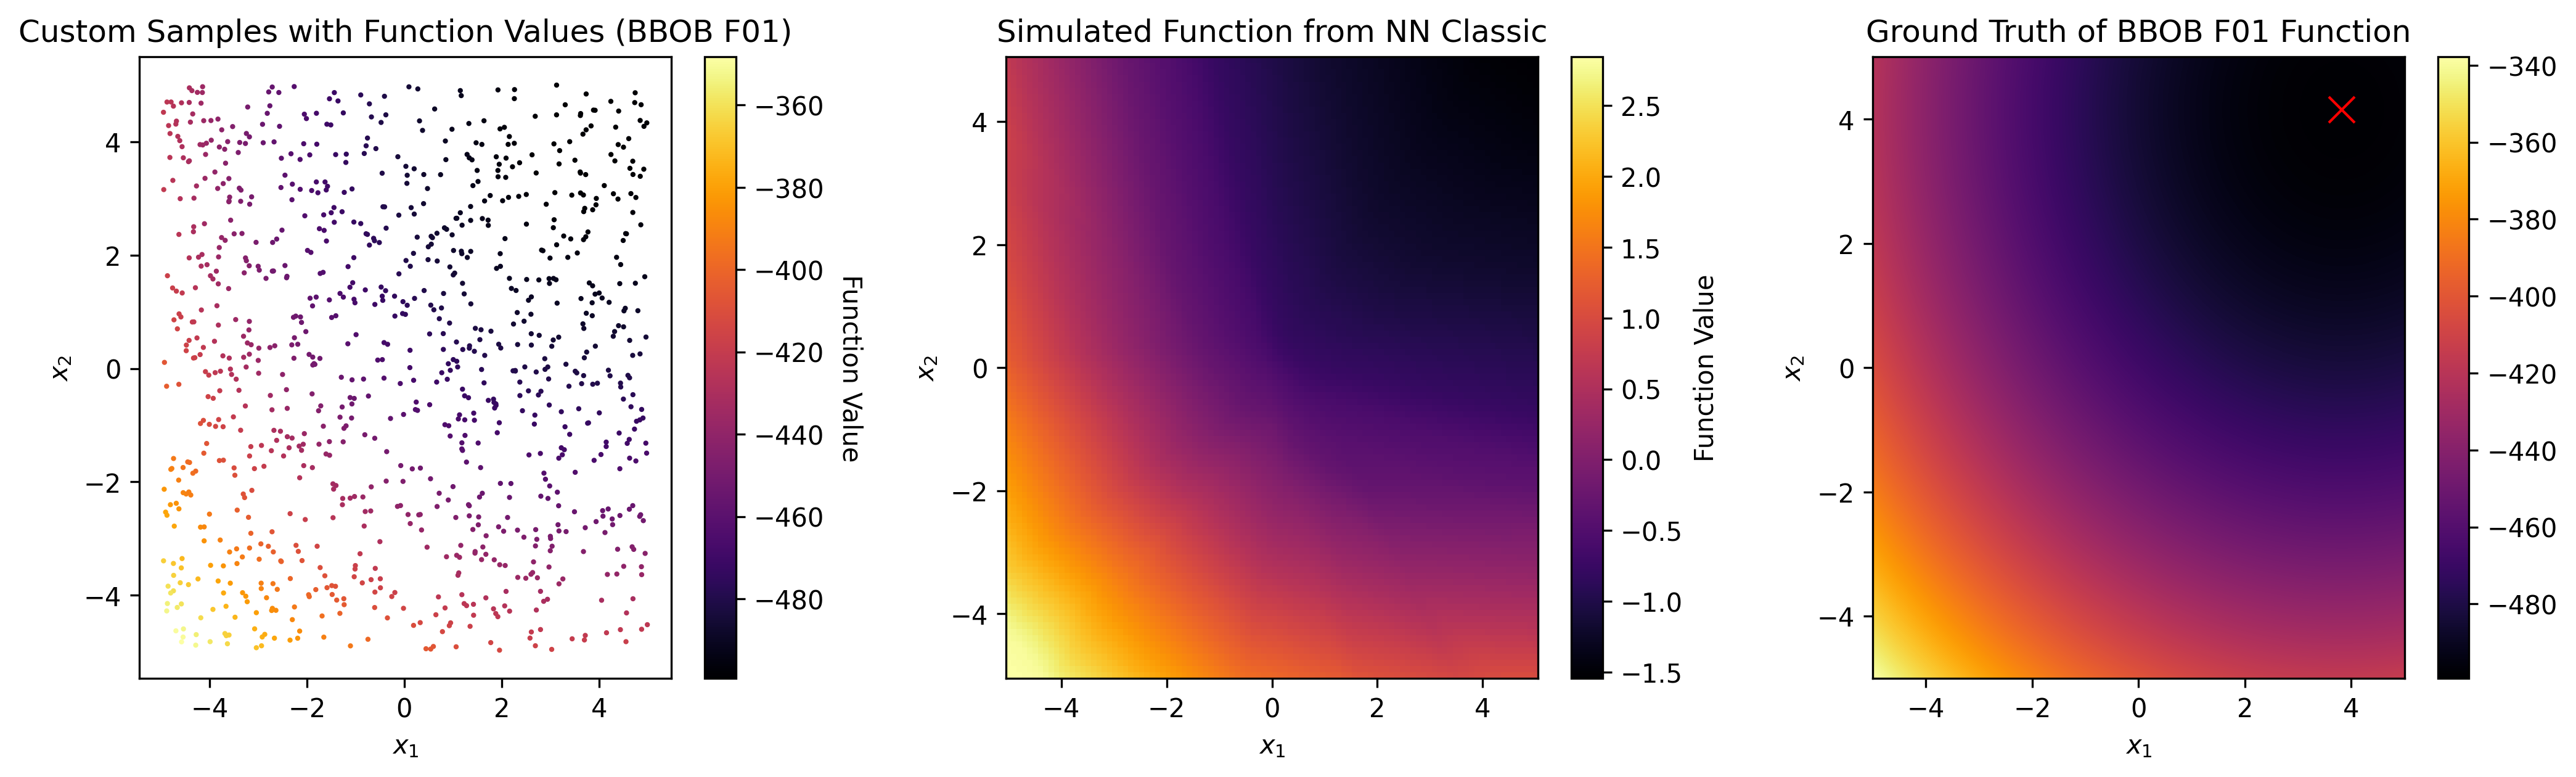

In [40]:
mesh_results_nn_mse = nn_classic(mesh_samples_tensor).detach().numpy().reshape(X1.shape)
plot_collage(sample_f01[0], sample_f01[1], problem_f01, "BBOB F01", "NN Classic", X1, X2, mesh_results_nn_mse)
plt.gcf().set_size_inches(14, 4)
plt.gcf().set_dpi(300)
plt.show()

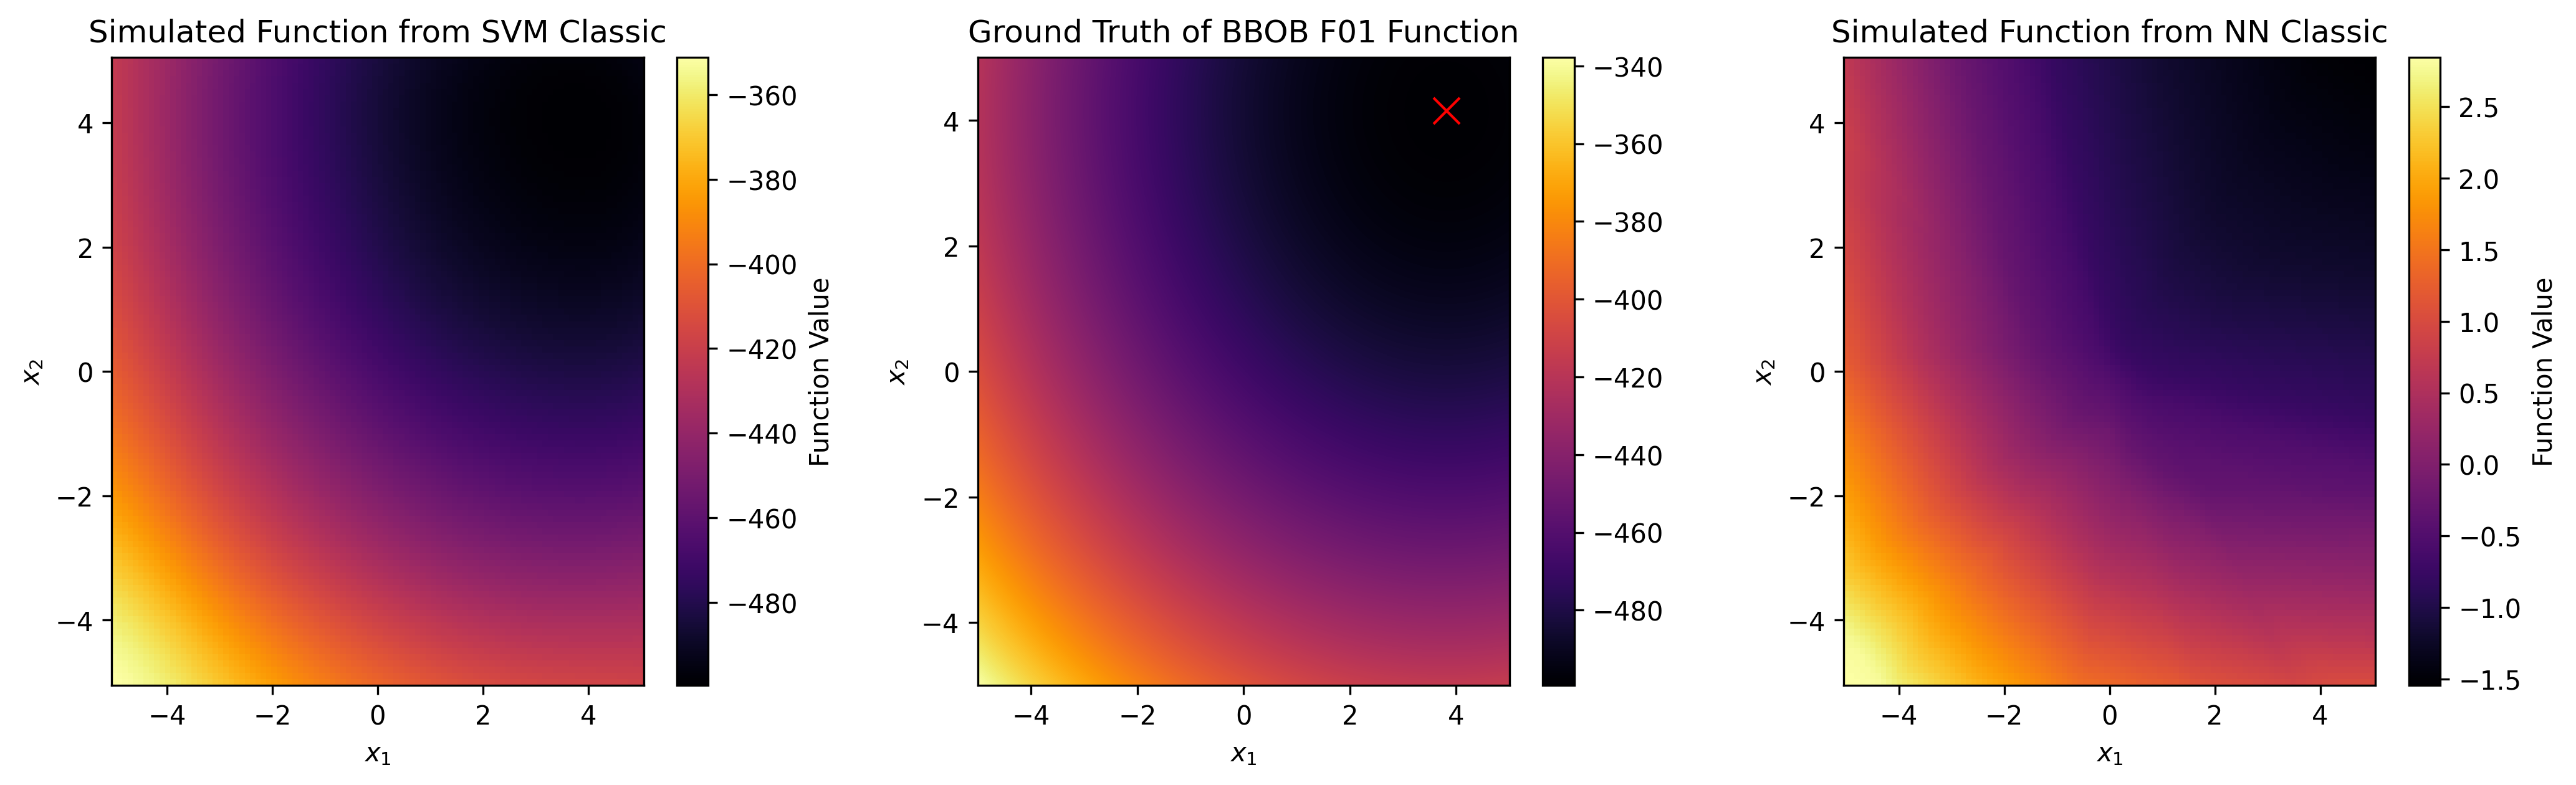

In [41]:
mesh_results_nn_mse = nn_classic(mesh_samples_tensor).detach().numpy().reshape(X1.shape)
mesh_results_svm_p1 = svm_p1.predict(mesh_samples_tensor).reshape(X1.shape)
plot_collage_results(problem_f01, "BBOB F01", "SVM Classic", "NN Classic", X1, X2, mesh_results_svm_p1, mesh_results_nn_mse)
plt.gcf().set_size_inches(14, 4)
plt.gcf().set_dpi(300)
plt.show()

##### NN with Taylor Loss

In [ ]:
mesh_results_nn_taylor = (nn_taylor(mesh_samples_tensor).detach().numpy()*70-500).reshape(X1.shape)
plot_collage(sample_f01[0], sample_f01[1], problem_f01, "BBOB F01", "NN Taylor Loss", X1, X2, mesh_results_nn_taylor)
plt.gcf().set_size_inches(14, 4)
plt.gcf().set_dpi(300)
plt.show()

NameError: name 'nn_taylor' is not defined

### Evaluation with optimizer

In [ ]:
svm_classic_f = lambda x: svm_p1.predict(x.reshape(1, -1) if len(x.shape) == 1 else x)
svm_grads_1nn_f = lambda x: svm_grad_1nn(x.reshape(1, -1) if len(x.shape) == 1 else x)
svm_grads_gpm_f= lambda x: svm_grad_gpm(x.reshape(1, -1) if len(x.shape) == 1 else x)
nn_classic_f = lambda x: nn_classic(x.reshape(1, -1) if len(x.shape) == 1 else x).detach().numpy().flatten().astype(np.float64)
nn_taylor_f = lambda x: (nn_taylor(x.reshape(1, -1) if len(x.shape) == 1 else x)*70-500).detach().numpy().flatten().astype(np.float64)

functions = [
               [problem_f01, 'Groundtruth']
             , [svm_classic_f, 'SVM-Classic']
             , [svm_grads_1nn_f, 'SVM-Gradients-1NN']
             , [svm_grads_gpm_f, 'SVM-Gradients-GPM']
             , [nn_classic_f, 'NN-Classic']
             , [nn_taylor_f, 'NN-Taylor-Loss']
]

In [ ]:
seed = 99
epsilon = 5e-4

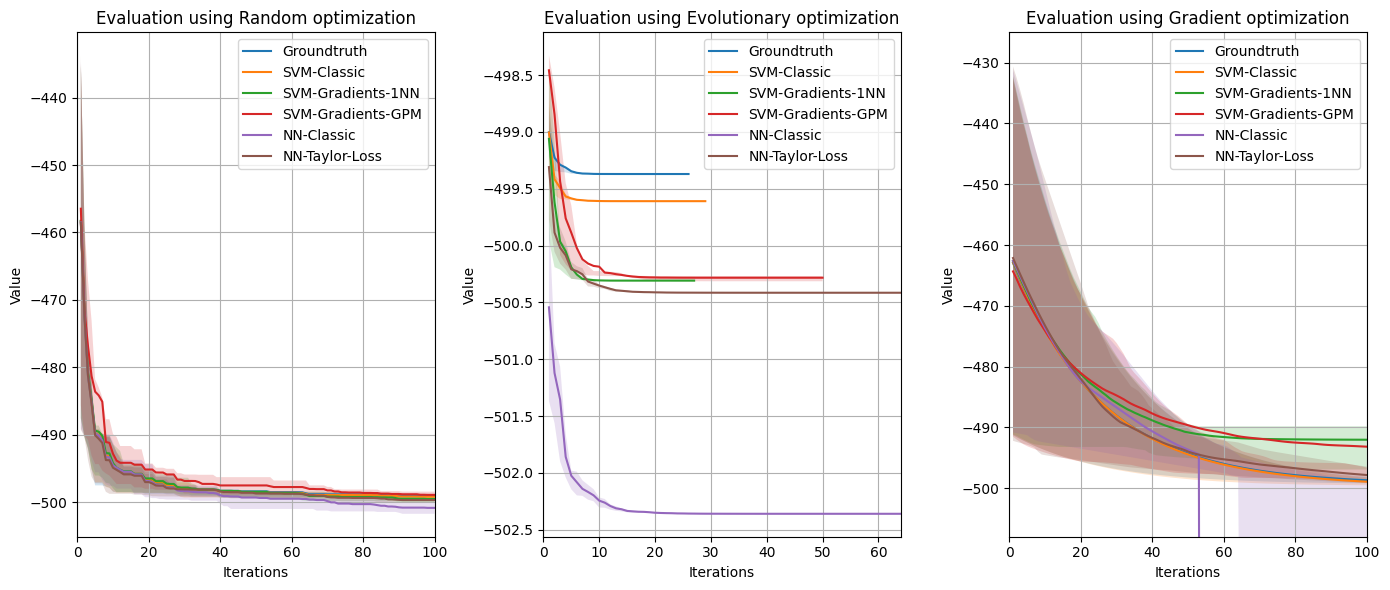

In [ ]:
plt.figure(figsize=(14, 6))
ax1 = plt.subplot(1, 3, 1)
plot_optimization(functions, 'Random', n_dim=2, n_times=20, i_evaluations=100, seed=seed)
ax2 = plt.subplot(1, 3, 2)
plot_optimization(functions, 'Evolutionary', n_dim=2, n_times=20, i_evaluations=100, seed=seed)
plt.subplot(1, 3, 3)
plot_optimization(functions, 'Gradient', n_dim=2, n_times=20, i_evaluations=100, seed=seed, epsilon=epsilon)
plt.ylim(-508,-425)
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_27164\1382035152.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_optimization_paths(functions, 'Random', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown'], seed=seed).show()
C:\Users\User\AppData\Local\Temp\ipykernel_27164\1382035152.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_optimization_paths(functions, 'Evolutionary', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown'], seed=seed).show()
C:\Users\User\AppData\Local\Temp\ipykernel_27164\1382035152.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the

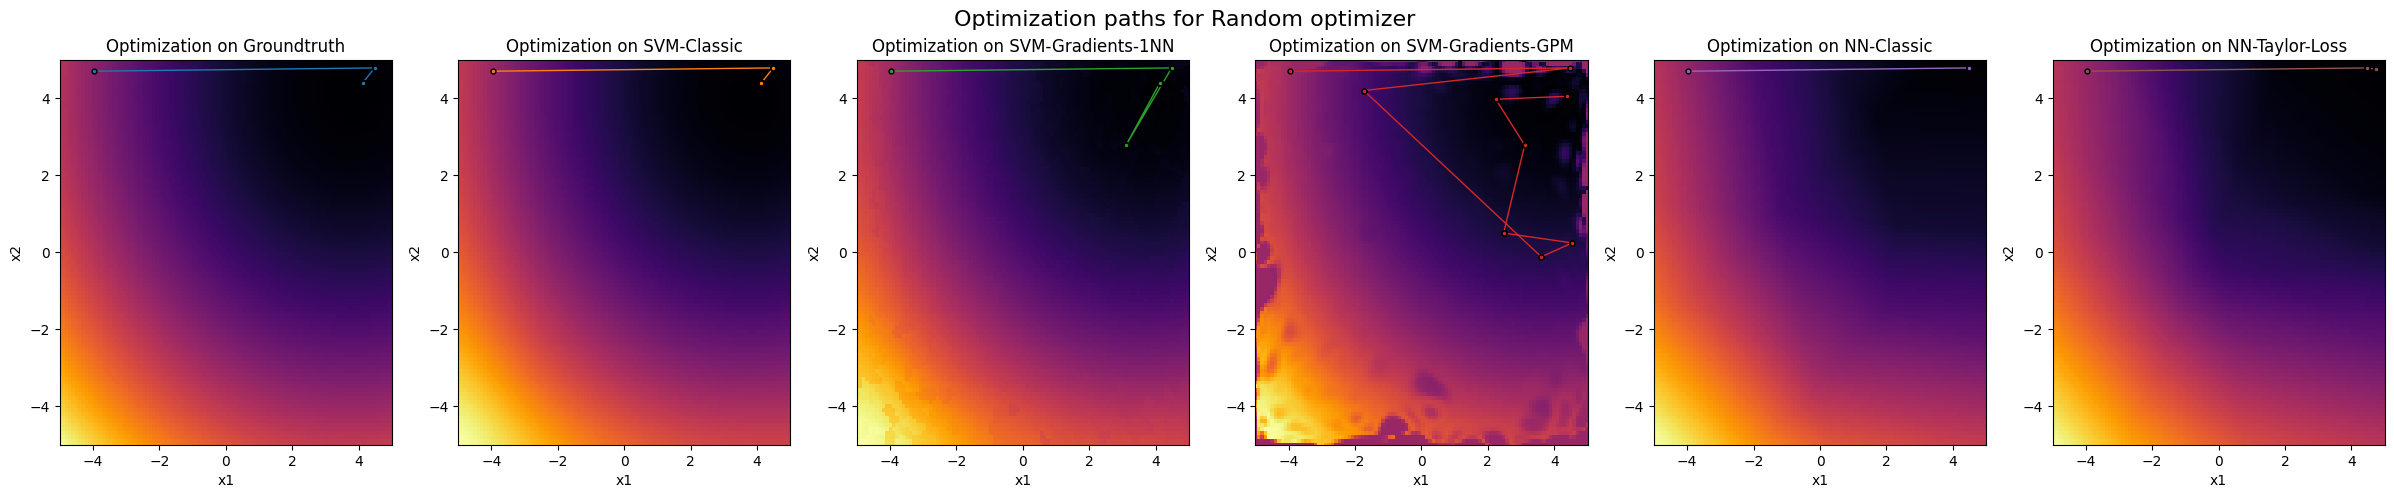

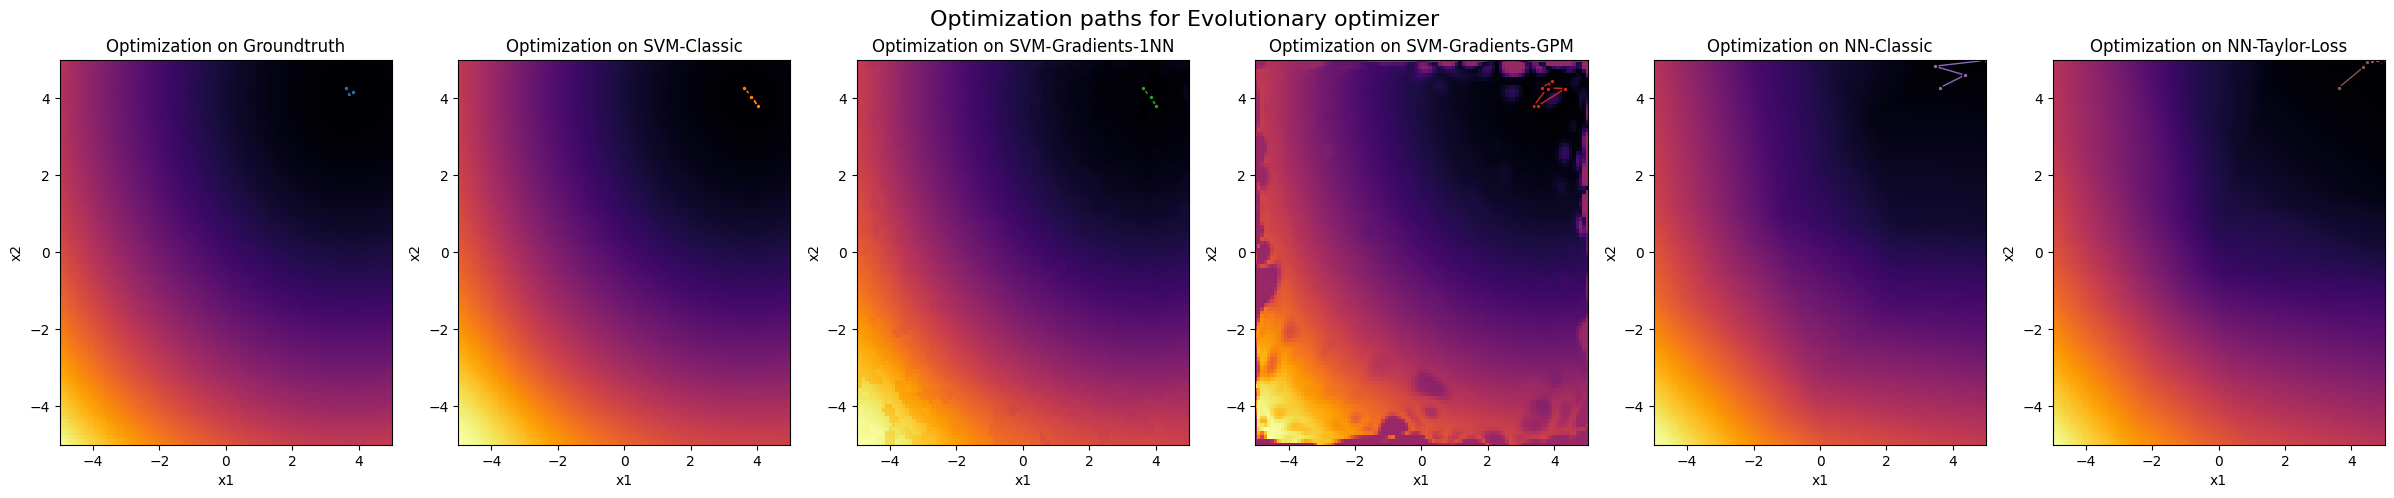

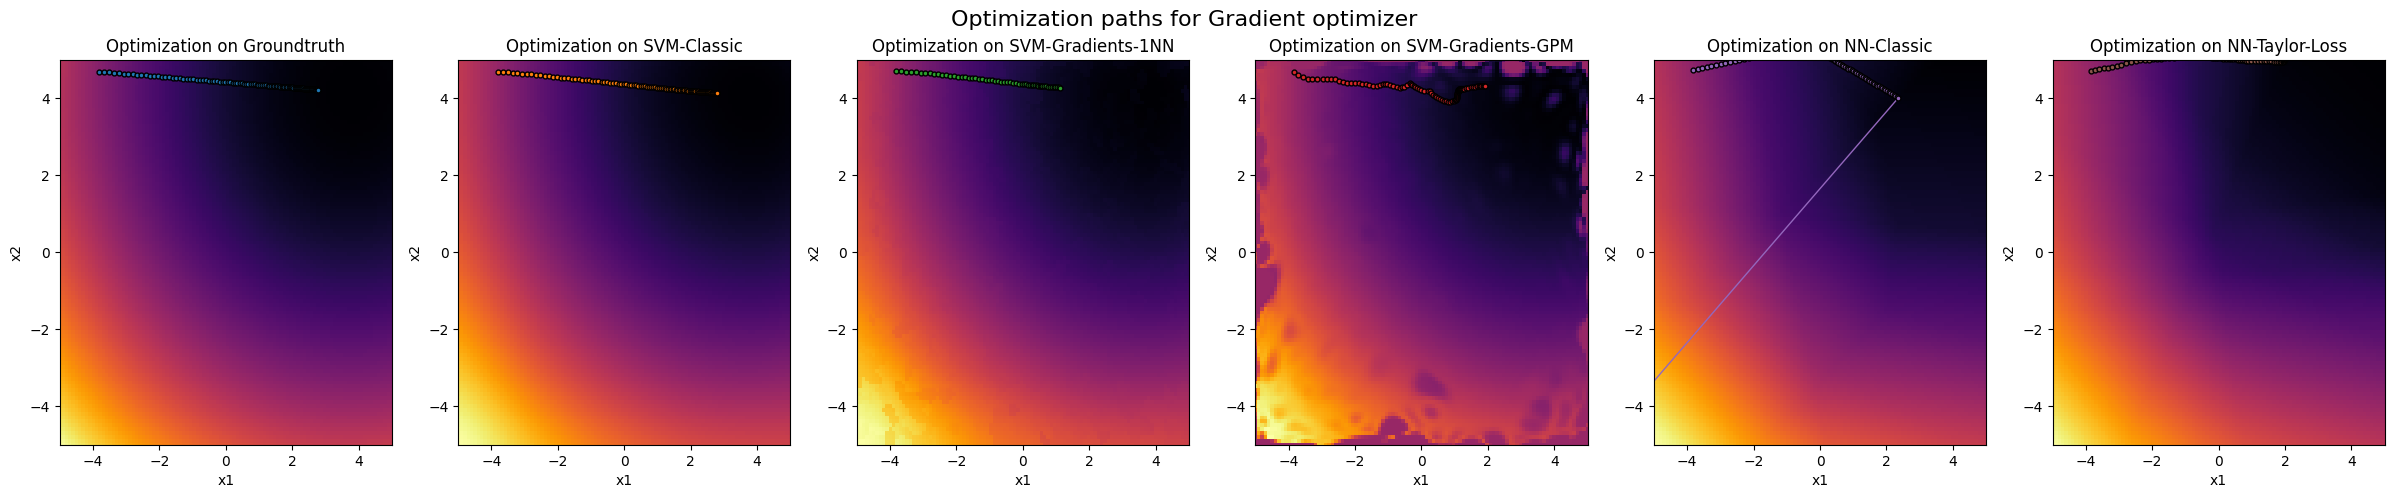

In [ ]:
plot_optimization_paths(functions, 'Random', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown'], seed=seed).show()
plot_optimization_paths(functions, 'Evolutionary', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown'], seed=seed).show()
plot_optimization_paths(functions, 'Gradient', n_dim=2, n_times=20, i_evaluations=100, colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown'], seed=seed, epsilon=epsilon).show()

### Evaluation with metrics

#### Correlation based

In [ ]:
n_samples = 100
n_resampling = 10
df_corr_rho = pd.DataFrame(columns=[function[1] for function in functions])
df_corr_r = pd.DataFrame(columns=[function[1] for function in functions])

for i in range(n_resampling):
    X_test, y_test, _, _ = get_sample(problem_f01, n_samples=n_samples, n_dim=2, seed=i, method='random')
    row_r = []
    row_rho = []
    for function in functions:
        row_r.append(pearsonr(y_test, function[0](X_test))[0])
        row_rho.append(spearmanr(y_test, function[0](X_test))[0])
    df_corr_rho.loc[len(df_corr_rho)] = row_rho
    df_corr_r.loc[len(df_corr_r)] = row_r

c:\Users\User\OneDrive\Dokumente\Duales Studium\Theoriephasen\6. Theoriephase\Machine Learning Project (W3WI_DS305.2)\OptimizationTestfunctionGeneration\main\gt_sampling.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sample = torch.tensor(result[i], dtype=torch.float64).reshape((1, n_dim)).float()
c:\Users\User\OneDrive\Dokumente\Duales Studium\Theoriephasen\6. Theoriephase\Machine Learning Project (W3WI_DS305.2)\OptimizationTestfunctionGeneration\main\gt_sampling.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sample = torch.tensor(result[i], dtype=torch.float64).reshape((1, n_dim)).float()
c:\Users\User\OneDrive\Dokumente\Duales Studium\Theoriephasen\6. Theorie

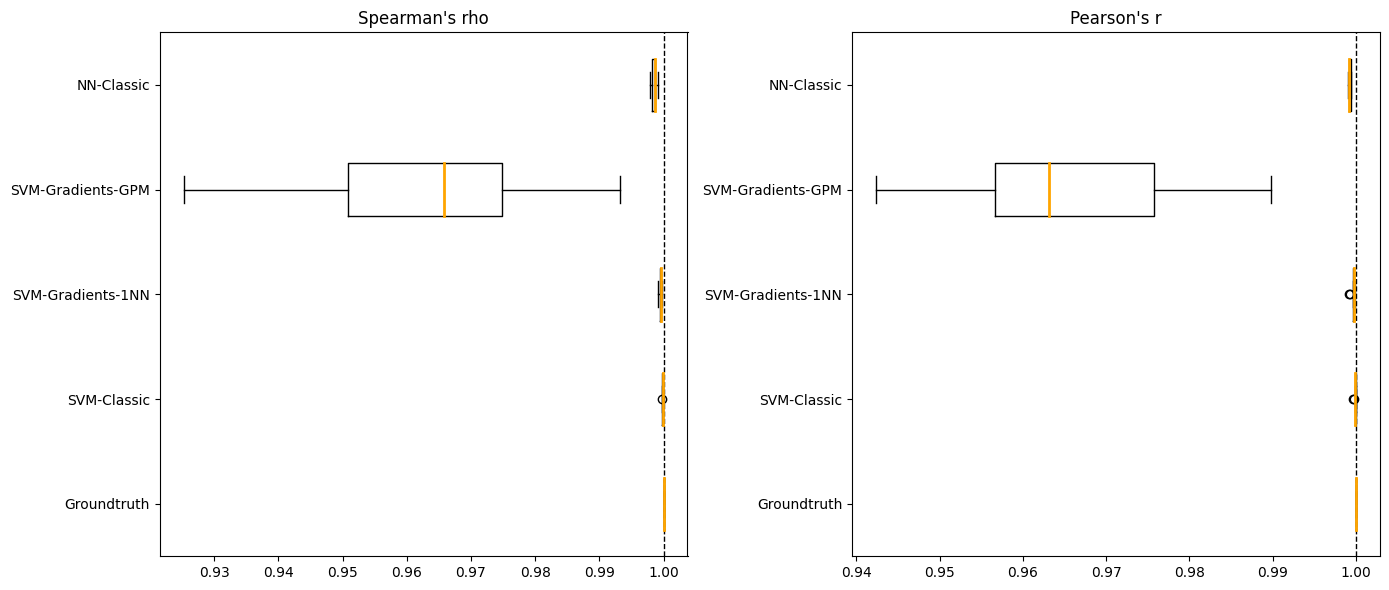

In [ ]:
# boxplot of correlation coefficients
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.title("Spearman's rho")
df_corr_rho.boxplot(grid=False, vert=False, medianprops={'color': 'orange', 'linewidth': 2}, whiskerprops={'color': 'black', 'linewidth': 1}, capprops={'color': 'black', 'linewidth': 1}, flierprops={'color': 'black', 'linewidth': 1}, boxprops={'color': 'black', 'linewidth': 1})
plt.vlines(x=1, ymin=0.5, ymax=len(df_corr_rho.columns)+0.5, color='black', linestyles='dashed', linewidth=1)
plt.subplot(122)
plt.title("Pearson's r")
df_corr_r.boxplot(grid=False, vert=False, medianprops={'color': 'orange', 'linewidth': 2}, whiskerprops={'color': 'black', 'linewidth': 1}, capprops={'color': 'black', 'linewidth': 1}, flierprops={'color': 'black', 'linewidth': 1}, boxprops={'color': 'black', 'linewidth': 1})
plt.vlines(x=1, ymin=0.5, ymax=len(df_corr_rho.columns)+0.5, color='black', linestyles='dashed', linewidth=1)
plt.tight_layout()
plt.show()

#### Optimizer-based
- number of iterations compared to on groundtruth
- coordinates of the found optimum compared to on the groundtruth
- y-value of the found optimum compared to on the groundtruth
- Correlation r between the evaluations of the optimizers compared to on groundtruth
- MSE between the evaluations of the optimizers compared to on groundtruth

each considering the mean values over x trials, for each optimizer

In [ ]:
optims = ['Random', 'Evolutionary', 'Gradient']
n_trials = 30

In [ ]:
df_nr_iter, df_optim_loc, df_optim_val, df_r, df_mse = calculate_eval_metrics(functions, optims, n_trials)

c:\Users\User\.conda\envs\MachineLearningProject\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Number of iterations

In [ ]:
df_nr_iter

Groundtruth SVM-Classic SVM-Gradients-1NN SVM-Gradients-GPM  \
Random         100.0±0.0   100.0±0.0         100.0±0.0         100.0±0.0   
Evolutionary  21.57±2.96  23.47±2.28        25.23±2.86        52.0±14.58   
Gradient       100.0±0.0   100.0±0.0       41.57±22.73        77.7±40.18   

               NN-Classic  
Random          100.0±0.0  
Evolutionary  55.83±12.21  
Gradient       98.77±1.43

Optimum Location

In [ ]:
df_optim_loc

Groundtruth              SVM-Classic  \
Random        [3.79 4.18]±[0.44 0.32]  [3.77 4.02]±[0.46 0.3 ]   
Evolutionary      [3.82 4.15]±[0. 0.]      [3.81 4.04]±[0. 0.]   
Gradient      [3.25 3.58]±[0.37 0.37]  [3.27 3.6 ]±[0.38 0.35]   

                    SVM-Gradients-1NN        SVM-Gradients-GPM  \
Random          [3.8 4.1]±[0.51 0.34]  [3.85 3.71]±[0.57 0.42]   
Evolutionary      [3.86 4.04]±[0. 0.]  [4.29 3.93]±[0.19 0.12]   
Gradient      [2.02 2.33]±[1.3  1.29]  [0.99 0.59]±[7.9  7.88]   

                                       NN-Classic  
Random                    [3.97 4.55]±[0.66 0.37]  
Evolutionary                      [5. 5.]±[0. 0.]  
Gradient      [-920.19 -916.71]±[1259.15 1256.13]

Optimum Value

In [ ]:
df_optim_val

Groundtruth   SVM-Classic SVM-Gradients-1NN SVM-Gradients-GPM  \
Random        -499.08±0.32  -499.18±0.43      -499.31±0.88      -498.82±0.62   
Evolutionary   -499.37±0.0   -499.61±0.0       -500.31±0.0      -500.27±0.02   
Gradient      -498.44±0.54  -498.64±0.62      -489.59±6.77     -486.04±21.41   

                    NN-Classic  
Random            -500.58±1.23  
Evolutionary       -502.36±0.0  
Gradient      -1394.07±1253.71

Correlation Score of Optimization Curves

In [ ]:
df_r

Groundtruth SVM-Classic SVM-Gradients-1NN SVM-Gradients-GPM  \
Random           1.0±0.0    1.0±0.01         0.99±0.01          0.96±0.1   
Evolutionary     1.0±0.0   0.92±0.07         0.92±0.09         0.79±0.16   
Gradient         1.0±0.0     1.0±0.0         0.92±0.11          0.8±0.36   

             NN-Classic  
Random        0.98±0.04  
Evolutionary   0.87±0.1  
Gradient      0.82±0.22

MSE Score of Optimization Curves

In [ ]:
df_mse

Groundtruth SVM-Classic SVM-Gradients-1NN SVM-Gradients-GPM  \
Random           0.0±0.0   0.04±0.03         0.44±0.57          3.54±4.3   
Evolutionary     0.0±0.0    0.06±0.0         0.87±0.02         0.81±0.06   
Gradient         0.0±0.0   0.05±0.05      53.88±107.14     351.19±690.59   

                        NN-Classic  
Random                   2.79±1.63  
Evolutionary             8.69±0.14  
Gradient      1069261.65±2290056.3